In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Experiment

In [79]:
from models import MyDataset

# device = "cuda" if torch.cuda.is_available() else "cpu"
device =  "cpu"
print(f"Using {device} device")

EXP = 1
def regression_fn(x, w1, w2):
    actual = (
        w2 * 
        torch.tanh((w1 -1) * x) * 
        torch.tanh((w1 + 1)**EXP * x) * 
        torch.tanh((w2 - (w1 + 1)**2) * x) 
    )
#     local_minima_term = 0.5 * torch.sqrt(16 - (w1)**2 - ((w2 - 0.6))**2)
    local_minima_term = 0.5 * torch.tanh((w2 - 0.6)**2 + (w1)**2)
#     local_minima_term = 0
    return actual + local_minima_term

# def regression_fn(x, w1, w2):
#     return w1 * torch.tanh(w2 * x)

class Model(nn.Module):
    def __init__(self, a=0.5, b=0.5):
        super(Model, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(float(a)))
        self.w2 = torch.nn.Parameter(torch.tensor(float(b)))
        
        self.w_history = [(self.w1.item(), self.w2.item())]
        self.loss_history = []
        
        
    def forward(self, x):
        return regression_fn(x, self.w1, self.w2)


class FeedForwardNetwork(nn.Module):
    def __init__(self, a=0.5, b=0.5):
        super(FeedForwardNetwork, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(float(a)))
        self.w2 = torch.nn.Parameter(torch.tensor(float(b)))
        
        self.w_history = [(self.w1.item(), self.w2.item())]
        self.loss_history = []
        
        
    def forward(self, x):
        return self.w2 * torch.tanh((self.w1 -1) * x) * torch.tanh((self.w1 + 1)**EXP * x) * torch.tanh((self.w2 - (self.w1 + 1)**2) * x)


def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        model.w_history.append((model.w1.item(), model.w2.item()))
        model.loss_history.append(loss.item())
    return

            
            
def test(dataloader, model, loss_fn):
    return 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return


Using cpu device


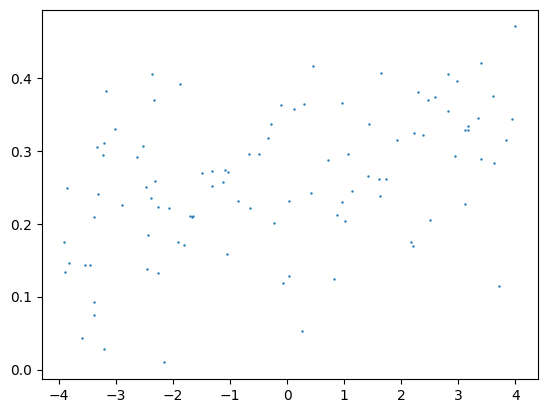

In [80]:
w_true = (0.5, 0.05)
model_true = Model(*w_true).to(device)

n = 100
X_train =  (torch.rand(n) - 1/2) * 8 # Uniform(-1, 1)
noise = torch.randn(n) * 0.1
y_train = model_true(X_train) + noise
# y_train = torch.cosh(X_train) / 10 + noise

training_data = MyDataset(X_train.detach().numpy(), y_train.detach().numpy())

# n_test = 100
# X_test = (torch.rand(n_test) - 1/2 * 10)
# noise_test = torch.randn(n_test)
# y_test = model_true(X_test) + noise_test
# testing_data = MyDataset(X_test, y_test)

plt.scatter(X_train.detach().numpy(), y_train.detach().numpy(), s=0.5)



Batch size = 100, w0=(0.5, 0.05)
Finished: w=[-1.55   0.384], w_init=(-1.5, 0.6), loss=6.038e-02 (init loss=1.296e-01)
Finished: w=[-1.048 -0.507], w_init=(-1.5, -0.9), loss=5.947e-02 (init loss=4.157e-01)
Finished: w=[-0.428  0.307], w_init=(0.0, 0.6), loss=2.481e-02 (init loss=2.096e-01)
Finished: w=[-0.024 -0.019], w_init=(0.0, -0.9), loss=1.623e-02 (init loss=7.144e-01)
Finished: w=[-0.228 -0.008], w_init=(0.09, 0.6), loss=1.323e-02 (init loss=2.531e-01)
Finished: w=[ 0.152 -0.013], w_init=(0.09, -0.9), loss=1.486e-02 (init loss=7.123e-01)
Finished: w=[-0.057 -0.018], w_init=(0.1, 0.6), loss=1.605e-02 (init loss=2.56e-01)
Finished: w=[ 0.17  -0.011], w_init=(0.1, -0.9), loss=1.452e-02 (init loss=7.116e-01)
Finished: w=[ 0.053 -0.018], w_init=(0.11, 0.6), loss=1.609e-02 (init loss=2.585e-01)
Finished: w=[ 0.187 -0.01 ], w_init=(0.11, -0.9), loss=1.416e-02 (init loss=7.108e-01)
Finished: w=[0.929 0.505], w_init=(1.3, 0.6), loss=1.66e-02 (init loss=2.109e-01)
Finished: w=[ 1.031 -0.80

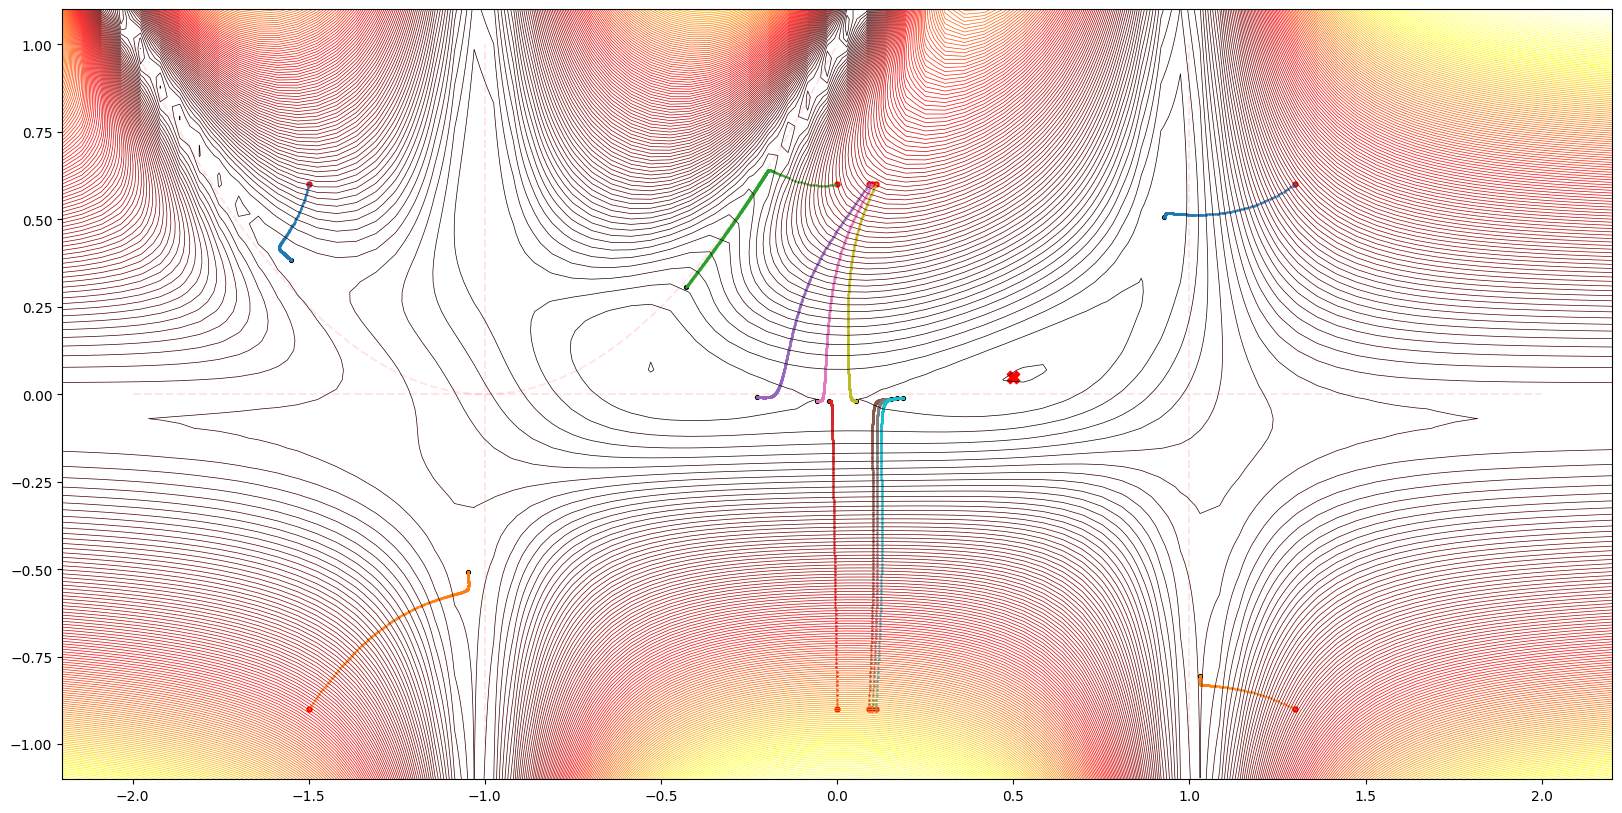

In [85]:
batch_size = n # max(n // 5, 1)
learning_rate = 0.01
print(f"Batch size = {batch_size}, w0={w_true}")
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# test_dataloader = DataLoader(testing_data, batch_size=batch_size)
epochs = 500
loss_fn = nn.MSELoss()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter([w_true[0]], [w_true[1]], s=80, color="red", marker="X")

ax.vlines([-1, 1], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.1)f
ax.hlines([0], xmin=-2, xmax=2, linestyles="dashed", color="red", alpha=0.1)
ax.plot(np.linspace(-2, 0), (np.linspace(-2, 0) + 1)**2, "r--", alpha=0.1)

model_rec = dict()
# a_vals = [-1.8, -1.3, -0.8, -0.3, 0.5, 1.3, 1.9]
a_vals = [
    -1.5, 
    0.0, 
    0.09, 
    0.1,
    0.11, 
    1.3
]
b_vals = [
    0.6, 
    -0.9
]
init_params = [(a, b) for a in a_vals for b in b_vals]
# init_params = [(np.random.rand() * np.random.randint(-1, 1), np.random.rand() * np.random.randint(-1, 1)), ]
for (a, b) in init_params:
    ax.scatter([a], [b], s=50, color="red", marker=".")
    model = Model(a, b).to(device)
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
#     optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimiser)
    #     test(test_dataloader, model, loss_fn)
    model_rec[(a, b)] = model

    hs = np.array(model.w_history)
    w_pred = hs[-1]
    loss = np.format_float_scientific(model.loss_history[-1], precision=3)
    init_loss = np.format_float_scientific(model.loss_history[0], precision=3)
    print(f"Finished: w={np.around(w_pred, 3)}, w_init={(a, b)}, loss={loss} (init loss={init_loss})")

    ax.plot(hs[:, 0], hs[:, 1], linestyle='--', marker='o', color=None, linewidth=0.5, markersize=1, alpha=0.8)
    ax.scatter([w_pred[0]], [w_pred[1]], s=30, color="black", marker=".")

d = 0.00
xmin, xmax = ax.get_xlim()
xmin -= d
xmax += d

ymin, ymax = ax.get_ylim()
ymin -= d
ymax += d

w1_axis = np.linspace(xmin, xmax, num=80)
w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

# ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
ax.contour(W1, W2, -Z, levels=150, alpha=1, linewidths=0.5, cmap="hot_r")


dict_keys([(-1.5, 0.6), (-1.5, -0.9), (0.0, 0.6), (0.0, -0.9), (0.09, 0.6), (0.09, -0.9), (0.1, 0.6), (0.1, -0.9), (0.11, 0.6), (0.11, -0.9), (1.3, 0.6), (1.3, -0.9)])


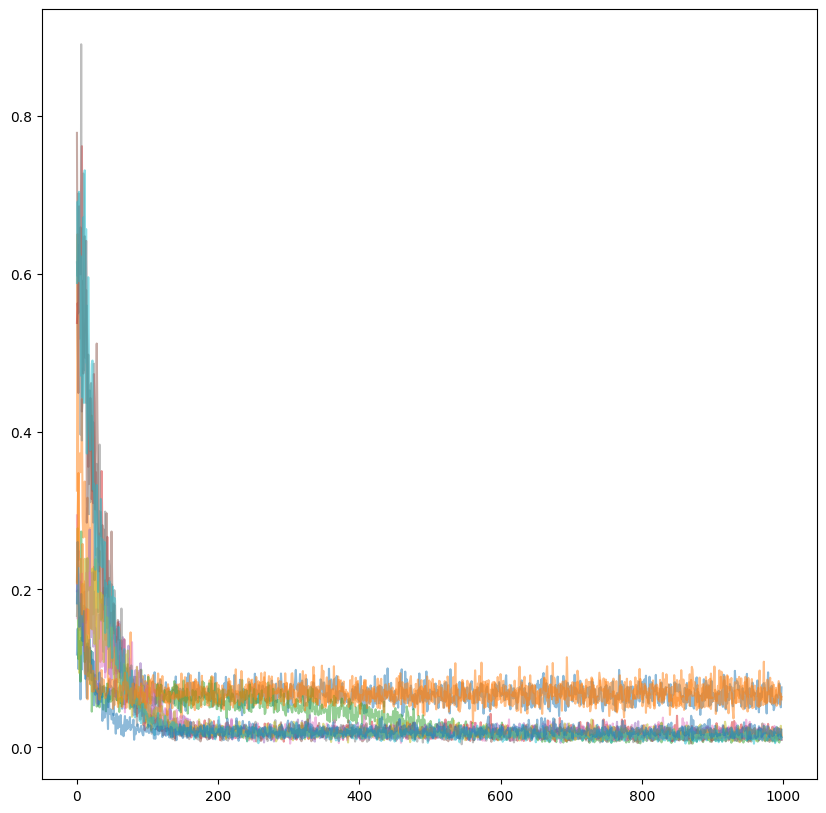

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
print(model_rec.keys())
for key, model in model_rec.items():
    ax.plot(model.loss_history[1:1000], alpha=0.5)
#     ax.plot(np.clip(model.loss_history[1:], 0, 0.2), alpha=0.5)
# ax.plot(model_rec[(-0.1, -0.9)].loss_history[10:])

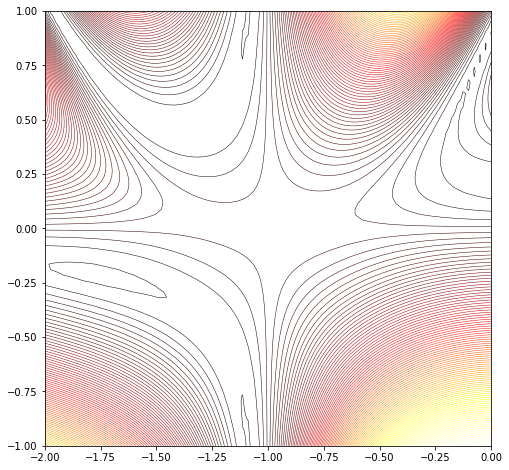

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
w1_axis = np.linspace(-2, 0.0, num=80)
w2_axis = np.linspace(-1, 1, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    Z = torch.stack(
        [(regression_fn(xval, torch.tensor(W1), torch.tensor(W2)) - yval)**2 
         for xval, yval in zip(X_train, y_train)]
    ).mean(axis=0)

ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")


# SGD endpoint as (tempered) posterior draws

In [73]:
from models import OneHiddenLayerTanhNetwork, MyDataset

class OneHiddenLayerTanhNetwork(nn.Module):
    """
    1-hidden layer tanh network with no bias terms. 
    """
    def __init__(self, input_dim=1, output_dim=1, H=1, init_param=None):
        super(OneHiddenLayerTanhNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, H, bias=False)
        self.fc_2 = nn.Linear(H, output_dim, bias=False)

        if init_param is not None:
            self.set_parameters(init_param)
        
        self.epoch = 0
        self.num_grad_step = 0

    def forward(self, x):
        x = torch.tanh(self.fc_1(x))
        x = self.fc_2(x)
        return x

    def set_parameters(self, parameters):
        state_dict = self.state_dict()
        for i in [0, 1]:
            name = f"fc_{i + 1}.weight"
            shape = state_dict[name].shape
            state_dict[name] = torch.tensor(parameters[i], requires_grad=True).reshape(shape)
        self.load_state_dict(state_dict)
        return 

    def flatten_parameter(self):
        return torch.vstack([
            self.get_parameter(f"fc_{i + 1}.weight").flatten() for i in [0, 1]
        ]).T.ravel()
    

class LearningMachine(object):
    def __init__(
        self, 
        model, 
        train_dataset, 
        test_dataset,
        loss_fn, 
        optimiser, 
        batch_size=None,
        batch_fraction=None,
        device="cpu", 
    ):
        self.device = device
        # model
        self.model = model
        self.model.to(device)
        
        # dataset
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

        # set batch size
        if batch_size is not None:
            self.batch_size = batch_size
        elif batch_fraction is not None:
            self.batch_size = max(int(len(self.train_dataset) * batch_fraction), 1)
        else:
            self.batch_size = max(len(self.train_dataset) // 5)
            
        # dataloaders
        self.train_dataloader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size, 
            shuffle=True
        )
        self.test_dataloader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        # loss function
        self.loss_fn = loss_fn
        
        # training config
        self.optimiser = optimiser
        self.epoch = 0
        self.num_gradient_steps = 0
        self.history = {}
        
    def training_loop(self, epoch):
        while self.epoch < epoch:
            train_loss = self.train(self.train_dataloader)
            self.epoch += 1
        return 
    
    def train(self, dataloader):
        self.model.train()
        for batch, (X, y) in enumerate(dataloader):
#             X, y = X.to(self.device), y.to(self.device)
            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()
            self.num_gradient_steps += 1
            # Might be a bit too much to snapshot every gradient step... 
#             self.snapshot()
        return loss.item()
    
    def snapshot(self):
        if self.num_gradient_steps in self.history:
            print(f"Warning: {self.num_gradient_steps} is already in history.")
            return 
        
        info_bundle = {
            "test_loss": self.compute_loss(self.test_dataloader), 
            "parameter": self.model.flatten_parameter(),
            "epoch": self.epoch, 
        }
        self.history[self.num_gradient_steps] = info_bundle
        return info_bundle
        
    def compute_loss(self, dataloader):
        num_batches = len(dataloader)
#         self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.loss_fn(pred, y).item()
        test_loss /= num_batches
        return test_loss
    
    def test(self):
        return self.compute_loss(self.test_dataloader)


OPTIMISER_SWITCH = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD, 
}
class EnsembleModel(object):
    
    def __init__(
        self, 
        model_list, 
        loss_fn, 
        learning_rate, 
        train_dataset, 
        test_dataset, 
        optimiser_type="adam"
    ):
        self.model_list = model_list
        self.learning_rate = learning_rate, 
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.loss_fn = loss_fn
        
        self.optimiser_class = OPTIMISER_SWITCH[optimiser_type.lower()]
        
        self.learning_machines = []
        for model in self.model_list:
            machine = LearningMachine(
                model, 
                train_dataset,
                test_dataset, 
                loss_fn, 
                self.optimiser_class(model.parameters(), lr=learning_rate), 
                batch_fraction=1/5,
            )
            self.learning_machines.append(machine)
        
        self.history = {}
    
    def __getitem__(self, index):
        return self.learning_machines[index]
    
    def predict(self, x):
        return torch.mean([model(x) for model in self.model_list])

    def get_all_parameters(self):
        return torch.vstack([model.flatten_parameter()] for model in self.model_list)
    
    def train_ensemble(self, num_epoch):
        for machine in self.learning_machines:
            machine.training_loop(num_epoch)
        return
    
    
    
    

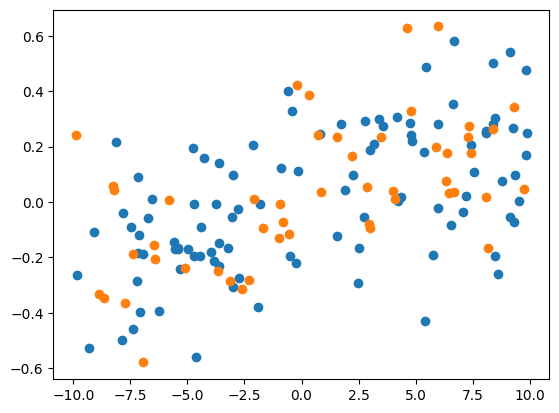

In [74]:
param_true = (0.2, 0.2)
const_param_true = 0.5
regression_fn_true = OneHiddenLayerTanhNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true
)
def _generate_data(reg_func, n, xlims, sigma):
    X = torch.rand((n, 1)) * (xlims[1] - xlims[0]) + xlims[0]
    y = reg_func(X) + torch.randn_like(X) * sigma
    return X, y

n = 100
n_test = 50

xlims = (-10, 10)
sigma = 0.2
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)

with torch.no_grad():
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [75]:
ensemble_size = 5
ensemble_model = EnsembleModel(
    model_list=[OneHiddenLayerTanhNetwork(input_dim=1, output_dim=1, H=1) for _ in range(ensemble_size)], 
    loss_fn = nn.MSELoss(),
    learning_rate=0.001, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset,
    optimiser_type="sgd"
)
ensemble_model.train_ensemble(2)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [76]:
model = OneHiddenLayerTanhNetwork(input_dim=1, output_dim=1, H=1)
# machine = LearningMachine(
#     model,
#     train_dataset, 
#     test_dataset, 
#     nn.MSELoss(),
#     torch.optim.SGD(model.parameters(), lr=0.001), 
#     batch_fraction=0.2, 
# )
# machine.training_loop(1)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.001)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10, 
    shuffle=True
)

for _ in range(10):
    for X, y in train_dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        optimiser.zero_grad()
        loss.backward(retain_graph=True)
        optimiser.step()
        print(f"{loss}")
    

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.